In [22]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA


print (glob.glob("../geom_aligned_curves/*.npy"))
# curve_bs = np.array(curve_bs)
curve_bs = np.load("../geom_aligned_curves/geomstats_aligned_to_first.npy")
curve_cs = np.load("../geom_aligned_curves/geomstats_aligned_to_frechet.npy")
files = np.load("../geom_aligned_curves/total_files_with_a.npy")

brava_num = 79

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_

['../geom_aligned_curves\\geomstats_aligned_to_first.npy', '../geom_aligned_curves\\geomstats_aligned_to_first_with_a.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet_with_a.npy', '../geom_aligned_curves\\total_files_with_a.npy']


- The first curve is not aligned in `curve_bs`.
- `curve_bs` and `curve_cs` have the same parameterization.

(79, 119, 3)


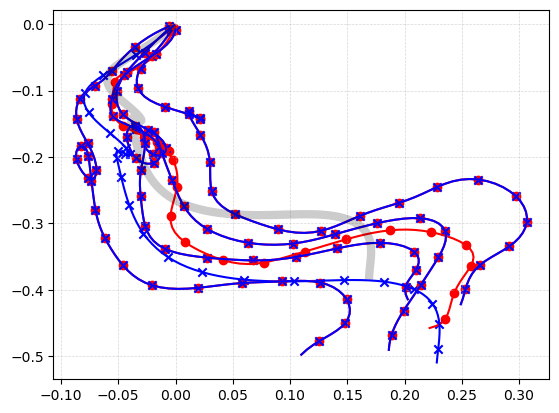

In [30]:
print (curve_bs.shape)
for i in range(5):
    plt.plot(curve_bs[i,:,0],curve_bs[i,:,1],c='r')
    plt.plot(curve_cs[i,:,0],curve_cs[i,:,1],c='b')
    plt.scatter(curve_bs[i,::5,0],curve_bs[i,::5,1],c='r')
    plt.scatter(curve_cs[i,::5,0],curve_cs[i,::5,1],c='b',marker='x')
plt.plot(mean_estimate[:,0],mean_estimate[:,1],c='k', linewidth=6, alpha=0.2)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.show()

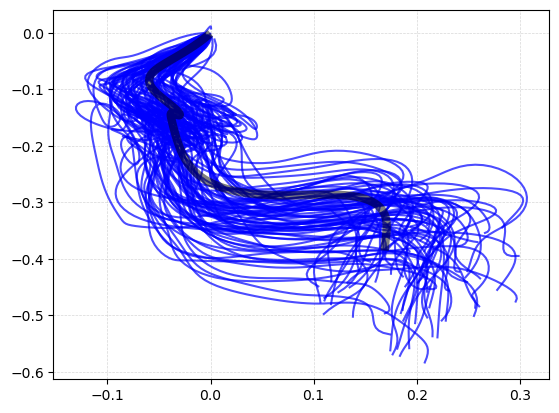

In [37]:

for i in range(curve_bs.shape[0]):
    plt.plot(curve_cs[i,:,0],curve_cs[i,:,1],c='b', alpha=0.7)
    # plt.scatter(curve_cs[i,::6,0],curve_cs[i,::6,1],c='b',marker='o', alpha=0.7)
plt.plot(mean_estimate[:,0],mean_estimate[:,1],c='k', linewidth=6, alpha=0.5)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.show()

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


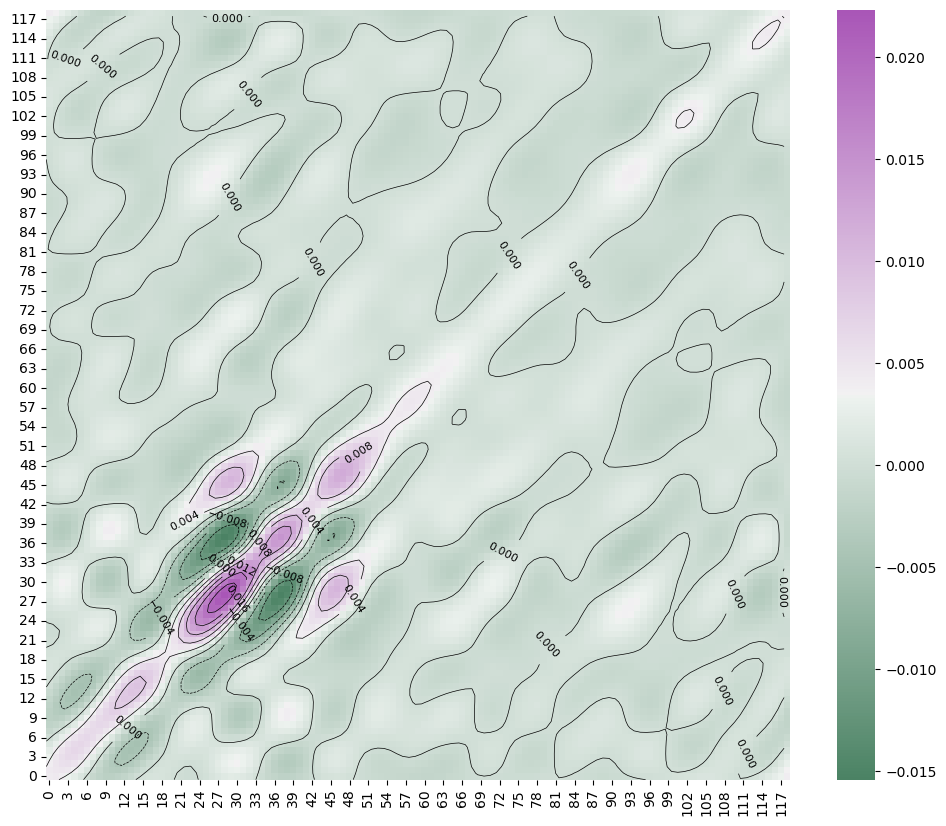

In [81]:
import numpy as np

def autocovariance_function(curvatures):
    """
    Compute the sample autocovariance function for a set of curvature profiles.

    Parameters:
    - curvatures: A (k, n) numpy array where k is the number of curvature profiles and
                  n is the number of points in each profile.

    Returns:
    - A (n, n) numpy array containing the sample autocovariance values for the curvature
      profiles at each pair of points.
    """
    k, n = curvatures.shape
    # Compute the mean curvature at each point across the k profiles
    mean_curvatures = np.mean(curvatures, axis=0)
    
    # Initialize an n x n matrix to store the autocovariance values
    autocovariance = np.zeros((n, n))
    
    # Calculate the sample autocovariance for each pair of points (t, s)
    for t in range(n):
        for s in range(n):
            sum_cov = np.sum((curvatures[:, t] - mean_curvatures[t]) * (curvatures[:, s] - mean_curvatures[s]))
            autocovariance[t, s] = sum_cov / (k - 1)
    
    return np.array(autocovariance)

# Example of usage:
# curvatures = np.random.rand(5, 10)  # This would be your actual data
# result = autocovariance_function(curvatures)
# print(result)



curvatures = []
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(curve_cs[i]*100)
    fft_c = remove_high_freq_components(c,0.08)
    curvatures.append(fft_c)
curvatures = np.array(curvatures)
autocovariance_values = autocovariance_function(curvatures)
# ax.xaxis_inverted()
sns.heatmap((autocovariance_values),cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=ax)
CS = ax.contour(autocovariance_values, colors='black', levels=10, linewidths=0.5)

# Adding contour labels
plt.clabel(CS, inline=True, fontsize=8)
ax.invert_yaxis()

(array([ 2.,  5., 14., 11.,  9., 10.,  7.,  5.,  5., 11.]),
 array([0.27756629, 0.32192281, 0.36627932, 0.41063584, 0.45499236,
        0.49934887, 0.54370539, 0.58806191, 0.63241842, 0.67677494,
        0.72113146]),
 <BarContainer object of 10 artists>)

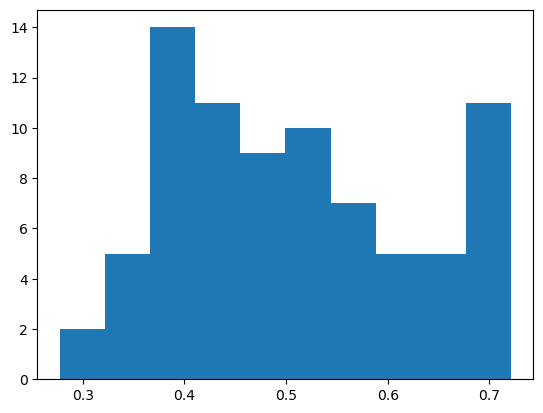

In [25]:
import seaborn as sns

g_dist = []
g_dist_mat = np.zeros((len(curve_bs),len(curve_bs)))
for i in range(len(curve_bs)):
    geodesic_distance = curves_r3.metric.dist(mean_estimate, curve_bs[i])
    g_dist.append(geodesic_distance)
plt.hist(g_dist,bins=10)



<Axes: >

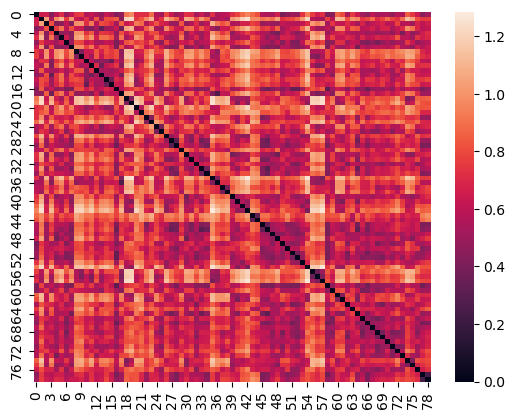

In [26]:

for i in range(len(curve_bs)):
    for j in range(len(curve_bs)):
        g_dist_mat[i,j] = curves_r3.metric.dist(curve_bs[i], curve_bs[j])

sns.heatmap(g_dist_mat)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


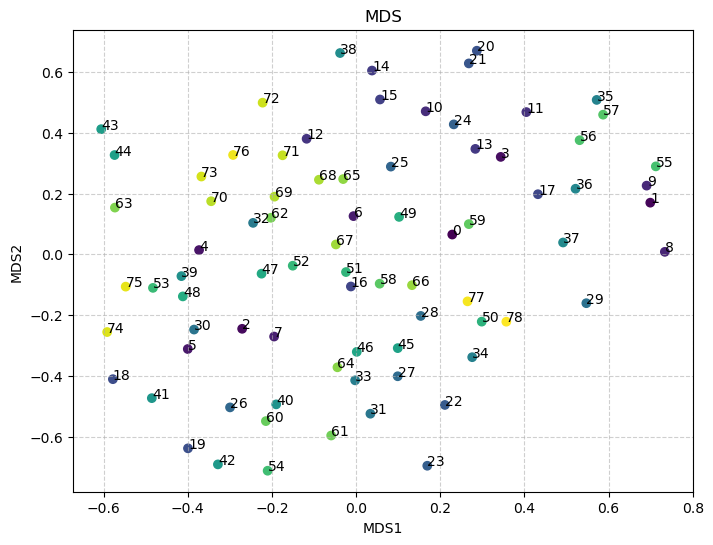

In [27]:
from sklearn.manifold import MDS

# 初始化MDS模型，设置降维到2维
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)

# 对距离矩阵应用MDS算法
results = mds.fit_transform(g_dist_mat)

# 提取两个维度
x = results[:, 0]
y = results[:, 1]

# 绘制结果
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=range(len(x)))
for i in range(len(results)):
    plt.annotate(i, (x[i], y[i]))
plt.title('MDS')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.grid(linestyle='--', alpha=0.6 )
# for i, txt in enumerate(range(1, g_dist_mat.shape[0]+1)):
#     plt.annotate(ruptureStatus[i], (x[i], y[i]))
# plt.savefig(root_dir+'MDS.png')
# plt.close()

Text(0, 0.5, 'PC2')

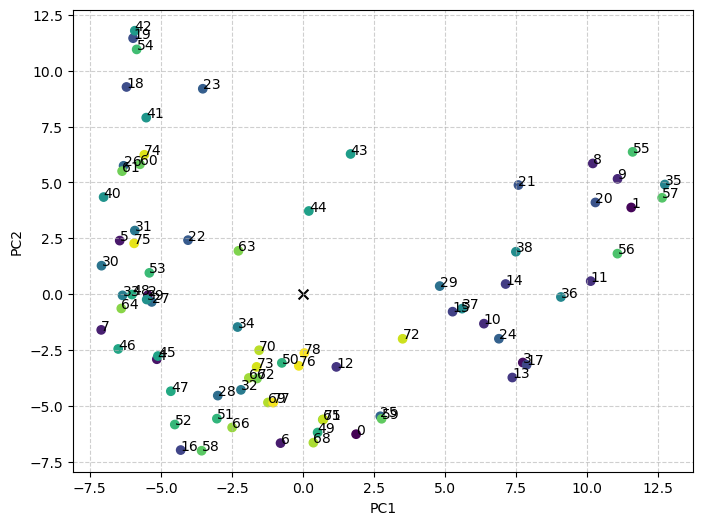

In [28]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



g_dist_center = np.mean(g_dist_mat, axis=0)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(g_dist_mat)
center_standardized = scaler.transform(g_dist_center.reshape(1, -1))

# 步骤3: 应用PCA
pca = PCA(n_components=2)  # 例如，降至2维进行可视化
principal_components = pca.fit_transform(data_standardized)
center_pc = pca.transform(center_standardized)

# 步骤4: 分析和可视化结果
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(principal_components[:, 0], principal_components[:, 1], c=range(len(x)))
for i in range(len(principal_components)):
    ax.annotate(i, (principal_components[i, 0], principal_components[i, 1]))
ax.scatter(center_pc[:, 0], center_pc[:, 1], c='k', marker='x', s=50)
ax.grid(linestyle='--', alpha=0.6 )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# # 筛选 x 坐标小于零的行
# filtered_data = principal_components[principal_components[:, 0] < 0.1]

# # 使用 numpy 的 polyfit 进行线性拟合
# # polyfit 返回拟合多项式的系数，其中 deg=1 表示线性拟合
# slope, intercept = np.polyfit(filtered_data[:, 0], filtered_data[:, 1], 1)
# ax.plot(filtered_data[:, 0], slope*filtered_data[:, 0] + intercept, color='k', label='Fitted Line', linewidth=1, alpha=0.3)


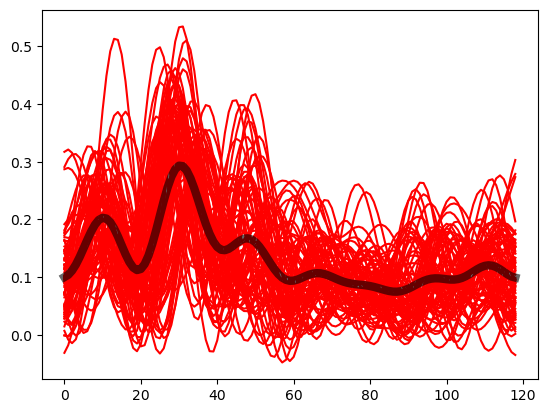

In [53]:
curvatures = np.array(curvatures)

for i in range(len(curvatures)):
    plt.plot(curvatures[i],c='r')
plt.plot(np.mean(curvatures,axis=0),c='k', linewidth=6, alpha=0.6)


显然需要“弹性的曲率”
dynamic time warping？

(79, 4)


array([0.39690109, 0.20759248, 0.18275613, 0.07918031])

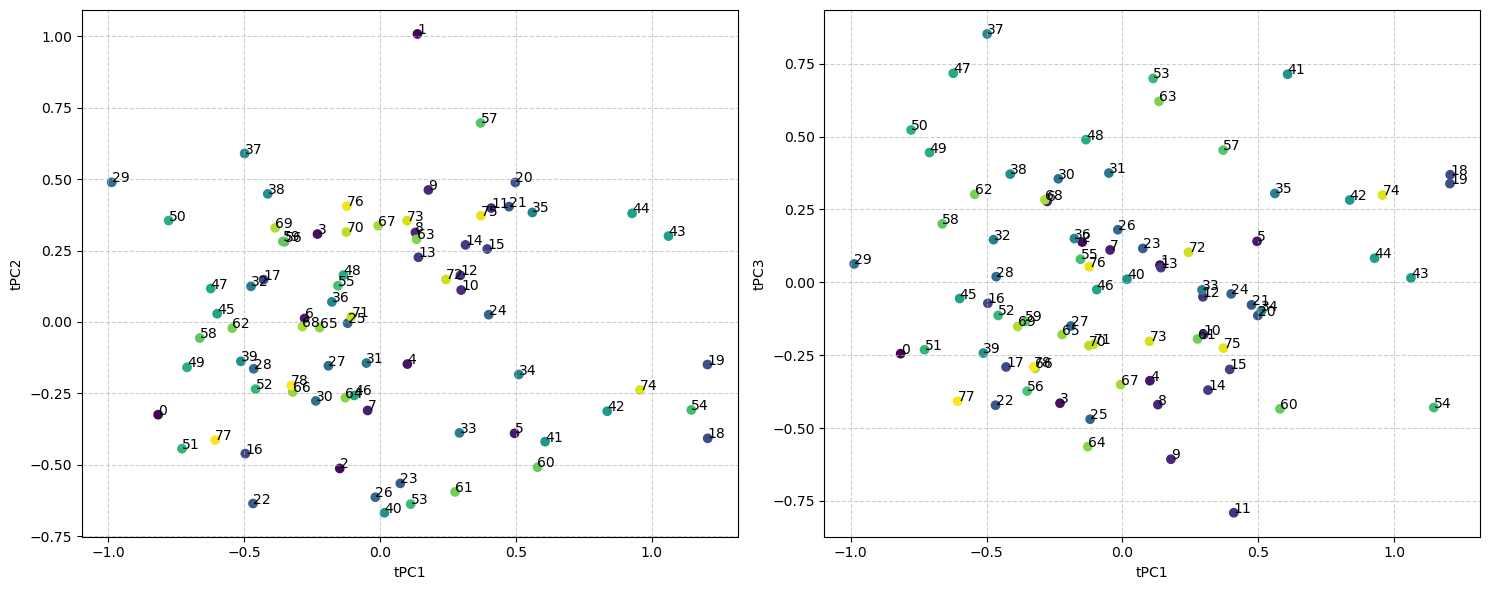

In [49]:


tpca = TangentPCA(curves_r3, n_components=4)
tpca.fit(curve_cs, base_point=mean_estimate)
tangent_projected_data = tpca.transform(curve_cs)

print (tangent_projected_data.shape)
# 步骤4: 分析和可视化结果
fig = plt.figure(figsize=(15, 6), dpi=100)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(tangent_projected_data[:, 0], tangent_projected_data[:, 1], c=range(len(x)))
for i in range(len(tangent_projected_data)):
    ax1.annotate(i, (tangent_projected_data[i, 0], tangent_projected_data[i, 1]))
ax1.grid(linestyle='--', alpha=0.6 )
ax1.set_xlabel('tPC1')
ax1.set_ylabel('tPC2')

ax2.scatter(tangent_projected_data[:, 0], tangent_projected_data[:, 2], c=range(len(x)))
for i in range(len(tangent_projected_data)):
    ax2.annotate(i, (tangent_projected_data[i, 0], tangent_projected_data[i, 2]))
ax2.grid(linestyle='--', alpha=0.6 )
ax2.set_xlabel('tPC1')
ax2.set_ylabel('tPC3')
plt.tight_layout()
tpca.explained_variance_ratio_